In [88]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [89]:
# Load dataset
file_csv= "Top_12_German_Companies NEW.csv" 
df = pd.read_csv(file_csv)

In [90]:
print("--- Dataset Overview ---")
print("Shape of the dataset:", df.shape)
print("First 5 rows of the dataset:")
print(df.head())


--- Dataset Overview ---
Shape of the dataset: (384, 11)
First 5 rows of the dataset:
         Company      Period      Revenue    Net Income  Liabilities  \
0  Volkswagen AG  12/31/2017   9750496618  5.168898e+08  21354201295   
1     Siemens AG  12/31/2017  19716237464  1.276840e+09  45009303223   
2     Allianz SE  12/31/2017  19458831198  1.600107e+09  48538978480   
3         BMW AG  12/31/2017  18808147150  9.601843e+08  35382107627   
4        BASF SE  12/31/2017  16895580815  1.797082e+09  28309420014   

        Assets       Equity        ROA (%)        ROE (%) Debt to Equity  \
0  54861302788  33507101493    942.175.618  1.542.627.668    637.303.746   
1  75268101508  30258798286  1.696.389.282  4.219.731.382  1.487.478.214   
2  69583711255  21044732775  2.299.542.624  7.603.361.452  2.306.466.848   
3  67327482638  31945375011    142.614.028  3.005.706.927  1.107.581.539   
4  68036567115  39727147101  2.641.347.127  4.523.561.449     71.259.635   

  percentage  Debt to Eq

In [91]:
print("Data Information:")
df.info()

Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384 entries, 0 to 383
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Company                     384 non-null    object 
 1   Period                      384 non-null    object 
 2   Revenue                     384 non-null    int64  
 3   Net Income                  384 non-null    float64
 4   Liabilities                 384 non-null    int64  
 5   Assets                      384 non-null    int64  
 6   Equity                      384 non-null    int64  
 7   ROA (%)                     384 non-null    object 
 8   ROE (%)                     384 non-null    object 
 9   Debt to Equity              384 non-null    object 
 10  percentage  Debt to Equity  384 non-null    object 
dtypes: float64(1), int64(4), object(6)
memory usage: 33.1+ KB


In [92]:
print("Summary Statistics:")
print(df.describe(include="all"))

Summary Statistics:
              Company      Period       Revenue    Net Income   Liabilities  \
count             384         384  3.840000e+02  3.840000e+02  3.840000e+02   
unique             12          32           NaN           NaN           NaN   
top     Volkswagen AG  12/31/2017           NaN           NaN           NaN   
freq               32          12           NaN           NaN           NaN   
mean              NaN         NaN  1.270992e+10  1.249025e+09  3.115579e+10   
std               NaN         NaN  4.095183e+09  5.445441e+08  1.139538e+10   
min               NaN         NaN  5.149850e+09  2.980309e+08  1.004637e+10   
25%               NaN         NaN  9.315161e+09  8.643813e+08  2.085174e+10   
50%               NaN         NaN  1.266963e+10  1.145476e+09  3.230659e+10   
75%               NaN         NaN  1.621724e+10  1.560234e+09  4.088942e+10   
max               NaN         NaN  1.990964e+10  2.884007e+09  4.976940e+10   

              Assets        Equ

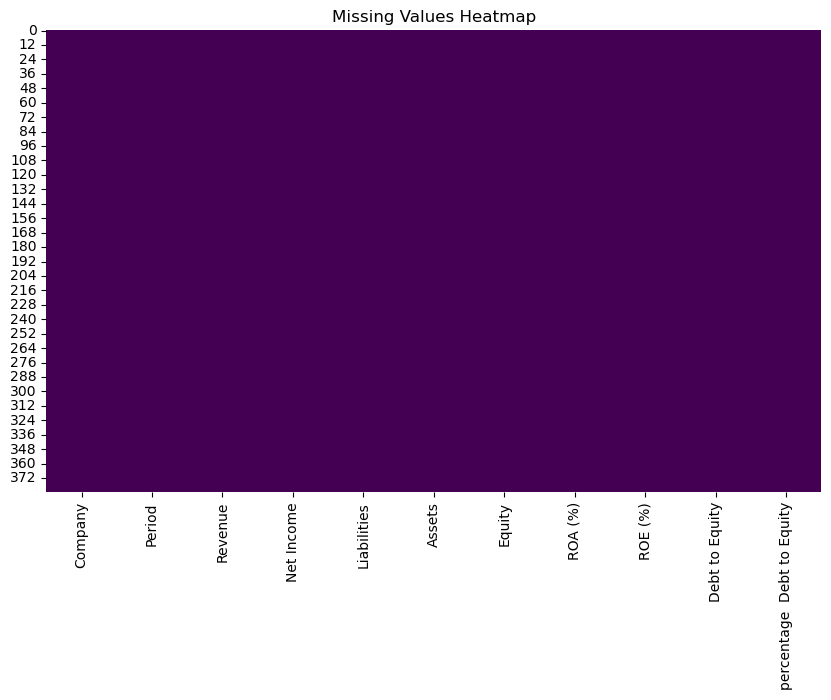

In [93]:
# Visualize missing values
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()

In [94]:
#handling missing values
df.fillna(df.mean(numeric_only=True), inplace=True)  # Fill numerical missing values with the mean
df.fillna("Unknown", inplace=True) 

In [95]:
# Data cleaning
if "percentage  Debt to Equity" in df.columns:
    df["percentage  Debt to Equity"] = (
        df["percentage  Debt to Equity"]
        .str.replace(",", ".", regex=False)  
        .str.rstrip("%")  
        .astype(float)
    )

# Clean numerical columns
columns_to_clean = ["Revenue", "Net Income", "Liabilities", "Assets", "Equity", "ROA (%)", "ROE (%)", "Debt to Equity"]
for col in columns_to_clean:
    df[col] = (
        df[col]
        .astype(str)  
        .str.replace(".", "", regex=False)  
        .str.replace(",", ".", regex=False)  
        .astype(float)  
    )

In [96]:
# Encode categorical features
if "Company" in df.columns:
    le = LabelEncoder()
    df["Company"] = le.fit_transform(df["Company"])

In [98]:
print("--- Cleaned Dataset Overview ---")
print("Shape of the dataset:", df.shape)
print("First 5 rows of the cleaned dataset:")
print(df.head())

--- Cleaned Dataset Overview ---
Shape of the dataset: (384, 11)
First 5 rows of the cleaned dataset:
   Company      Period       Revenue    Net Income   Liabilities  \
0       11  12/31/2017  9.750497e+09  5.168898e+09  2.135420e+10   
1       10  12/31/2017  1.971624e+10  1.276840e+10  4.500930e+10   
2        0  12/31/2017  1.945883e+10  1.600107e+10  4.853898e+10   
3        2  12/31/2017  1.880815e+10  9.601843e+09  3.538211e+10   
4        1  12/31/2017  1.689558e+10  1.797082e+10  2.830942e+10   

         Assets        Equity       ROA (%)       ROE (%)  Debt to Equity  \
0  5.486130e+10  3.350710e+10  9.421756e+08  1.542628e+09    6.373037e+08   
1  7.526810e+10  3.025880e+10  1.696389e+09  4.219731e+09    1.487478e+09   
2  6.958371e+10  2.104473e+10  2.299543e+09  7.603361e+09    2.306467e+09   
3  6.732748e+10  3.194538e+10  1.426140e+08  3.005707e+09    1.107582e+09   
4  6.803657e+10  3.972715e+10  2.641347e+09  4.523561e+09    7.125964e+07   

   percentage  Debt to Equ

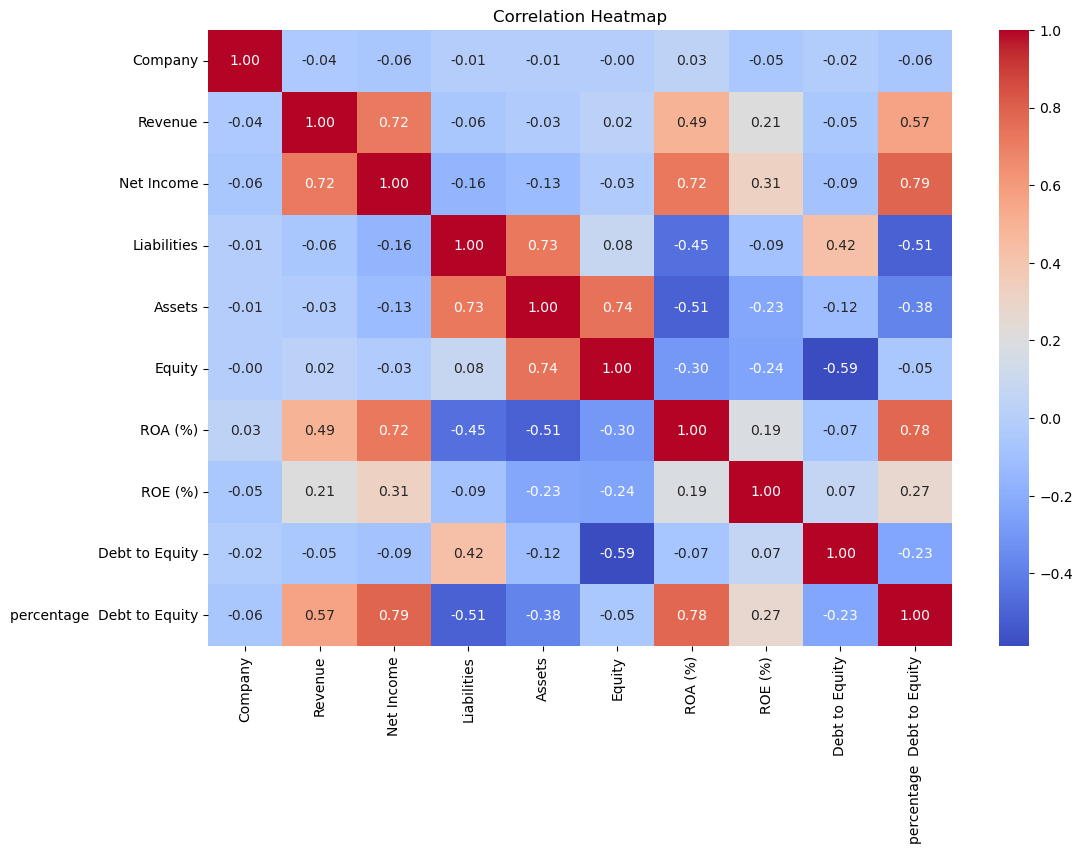

In [102]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()



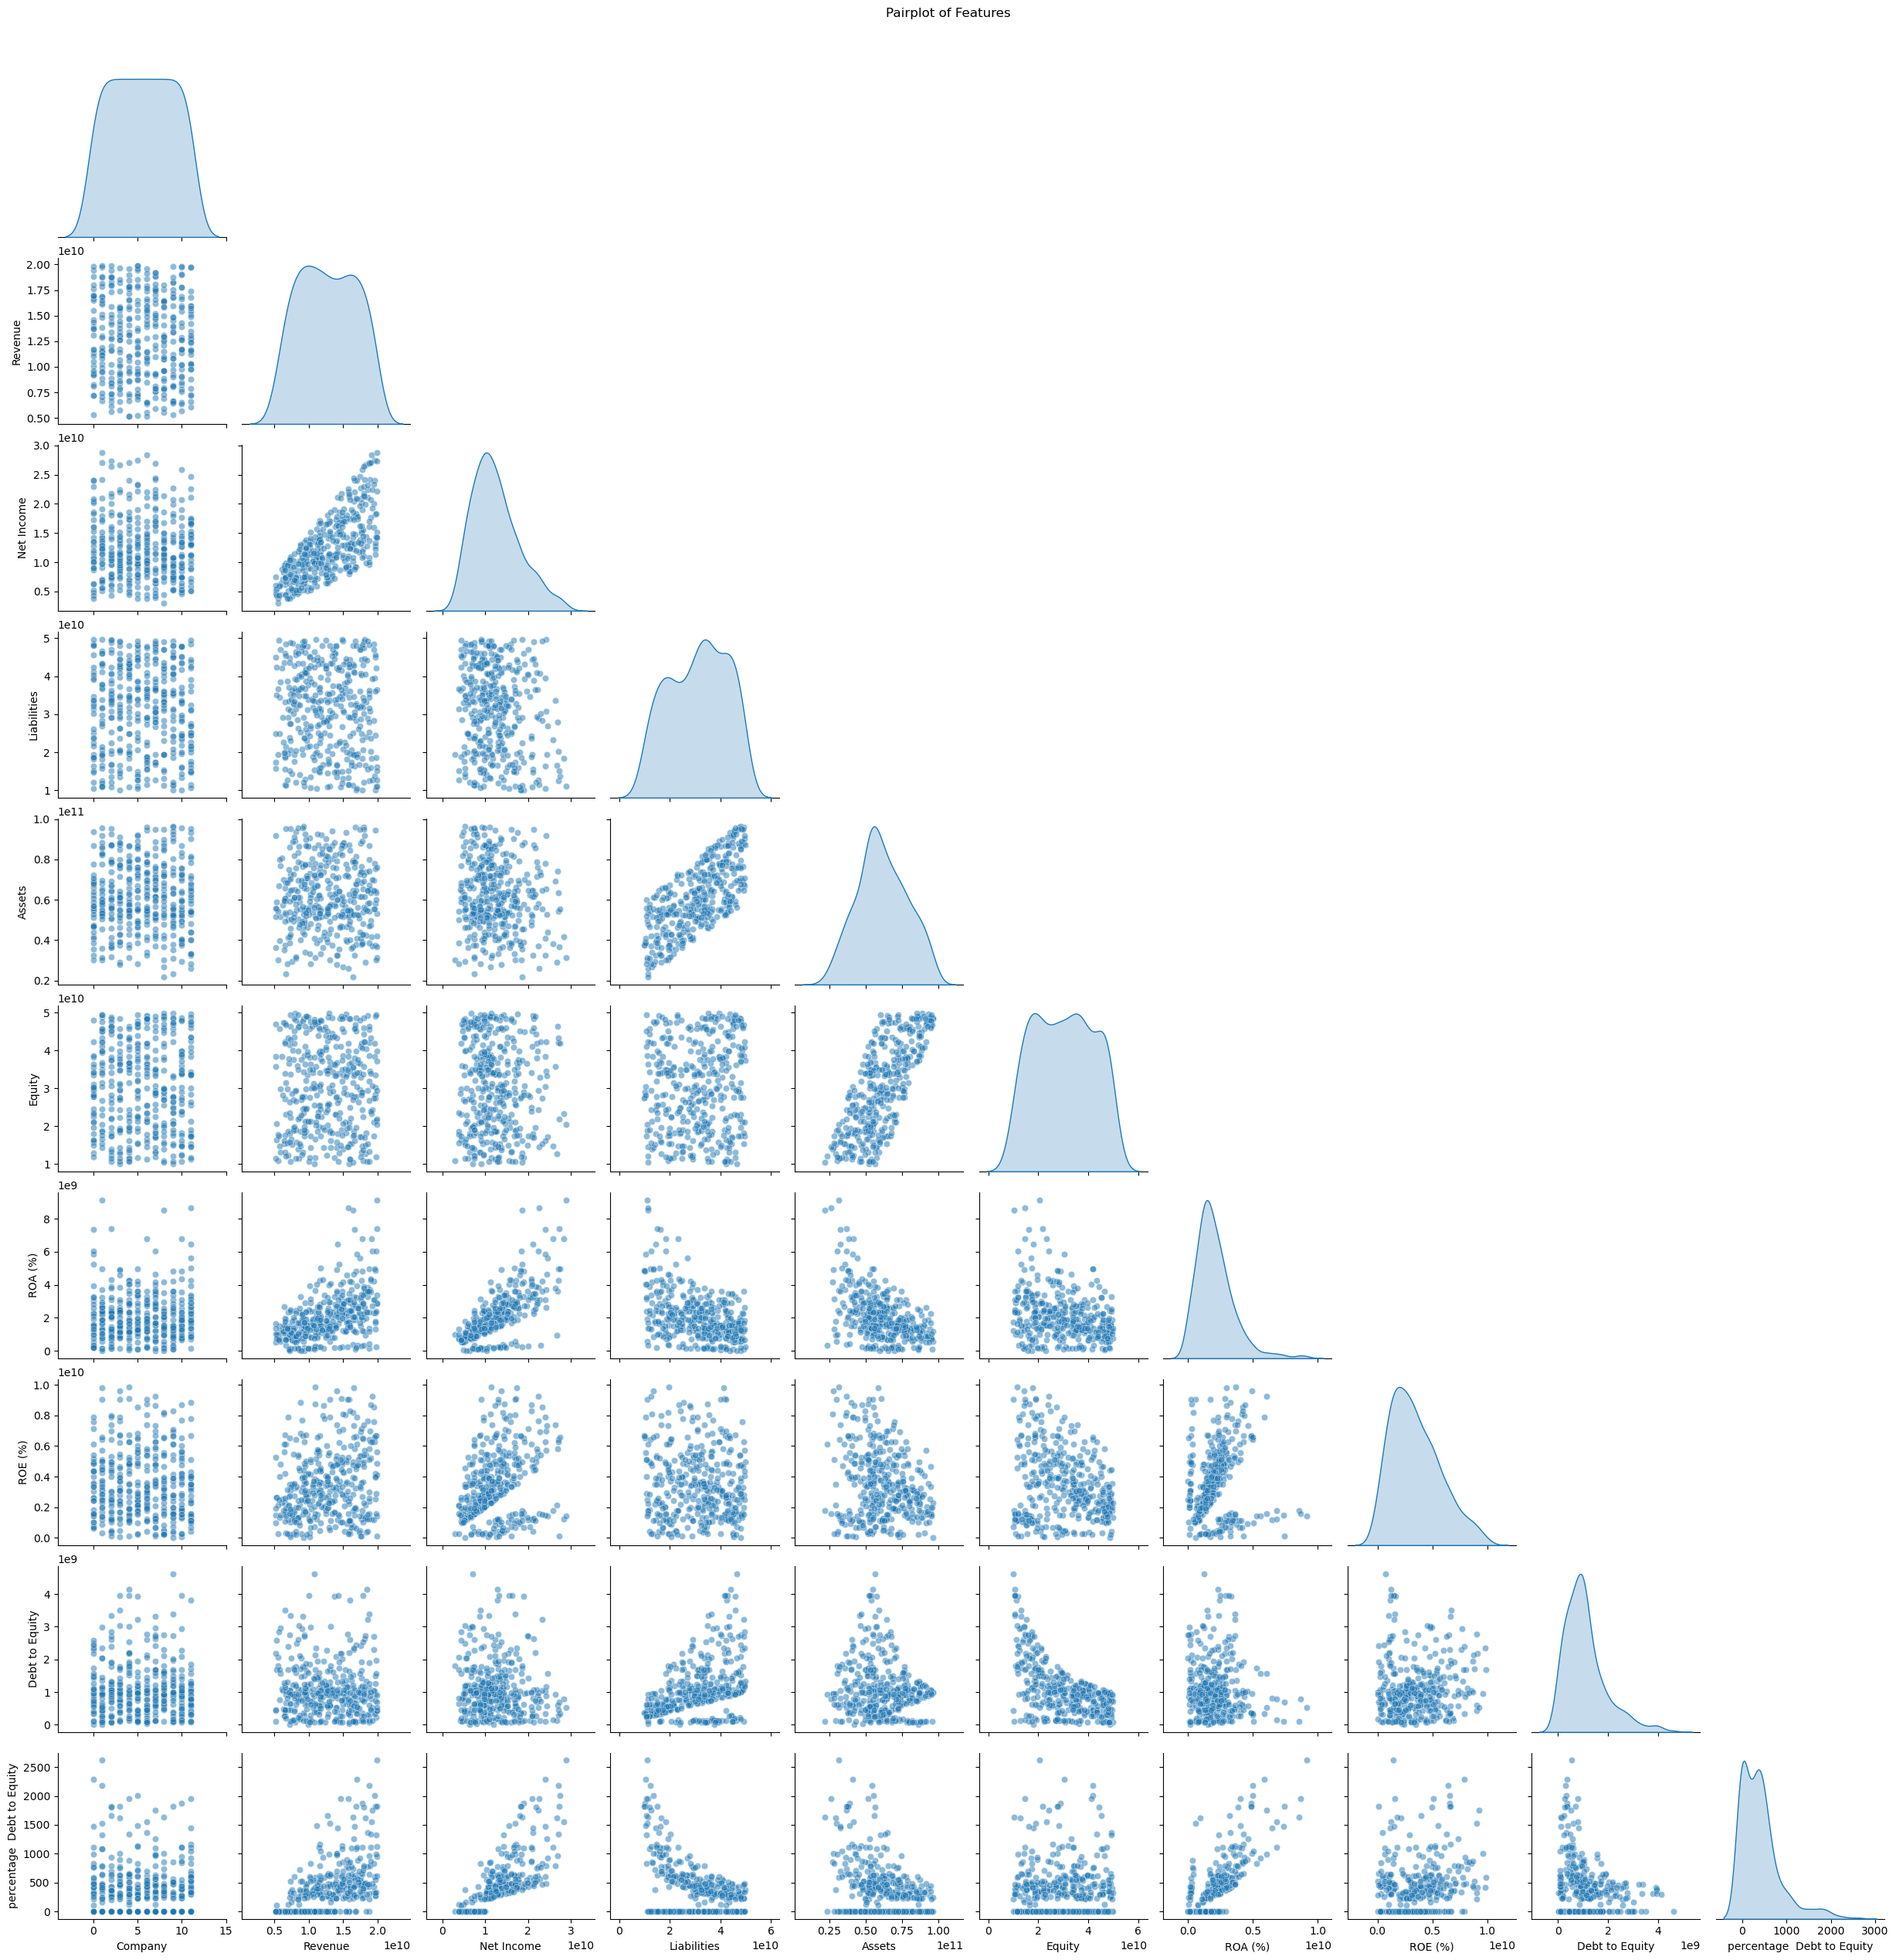

In [101]:
# Pairplot for exploratory visualization
sns.pairplot(df, diag_kind="kde", corner=True, plot_kws={'alpha':0.5})
plt.suptitle("Pairplot of Features", y=1.02)
plt.show()

In [103]:
features = ["Revenue", "Net Income", "Liabilities", "Assets", "Equity", "ROA (%)", "ROE (%)", "Debt to Equity"]
target = "percentage  Debt to Equity"
X = df[features]
y = df[target]

In [104]:
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [105]:
# Random Forest
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

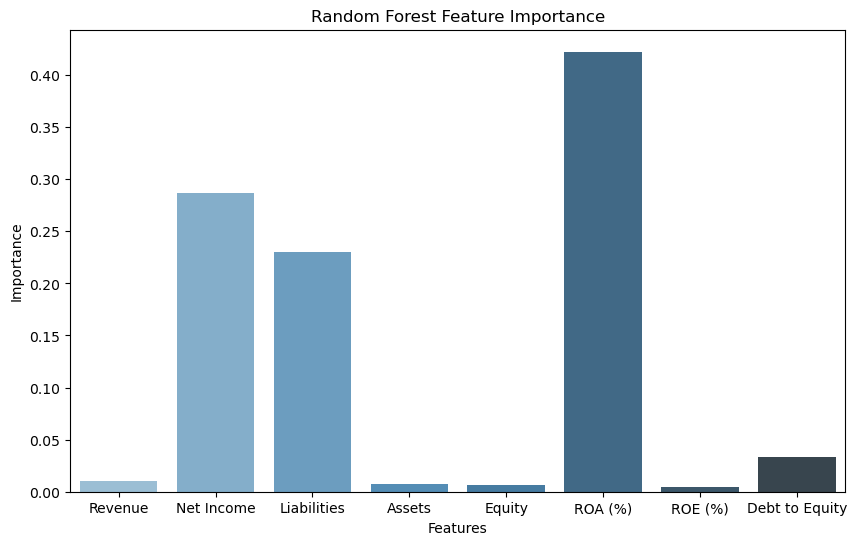

In [119]:
plt.figure(figsize=(10, 6))
feature_importances_rf = rf_model.feature_importances_
sns.barplot(x=features, y=feature_importances_rf, palette="Blues_d")
plt.title("Random Forest Feature")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

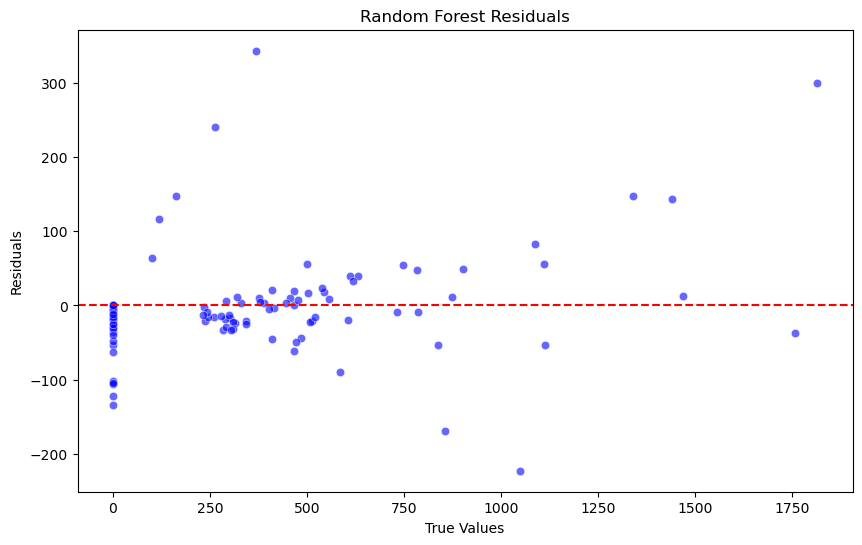

In [120]:
rf_residuals = y_test - rf_predictions
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=rf_residuals, color="blue", alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.title("Random Forest Residuals")
plt.xlabel("True Values")
plt.ylabel("Residuals")
plt.show()

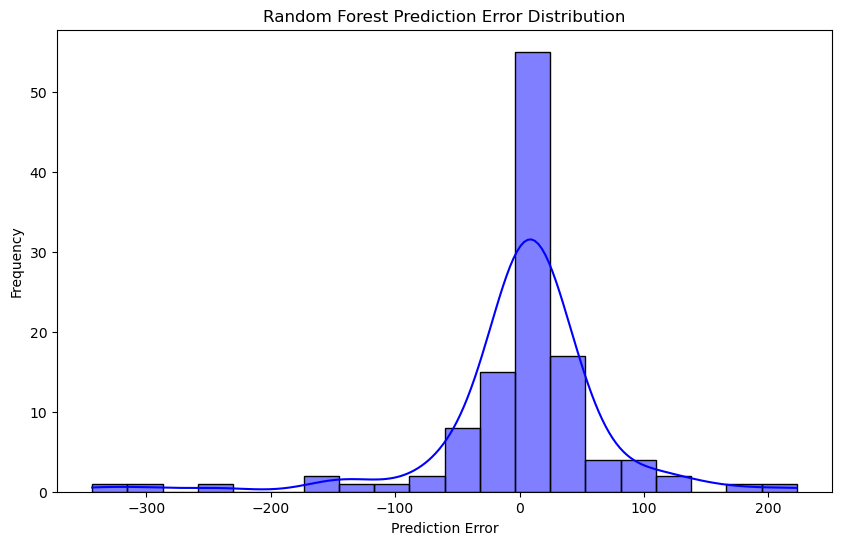

In [121]:
# Error Distribution for Random Forest
plt.figure(figsize=(10, 6))
rf_errors = rf_predictions - y_test
sns.histplot(rf_errors, kde=True, color="blue", bins=20)
plt.title("Random Forest Prediction Error Distribution")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.show()

In [122]:
# XGBoost
xgb_model = XGBRegressor(random_state=42, n_estimators=50, max_depth=3, eval_metric="rmse")
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)



In [123]:
# Evaluate models
def evaluate_model(name, y_true, y_pred):
    metrics = {
        "Model": name,
        "MAE": mean_absolute_error(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_pred),
        "R2 Score": r2_score(y_true, y_pred)
    }
    return metrics

rf_metrics = evaluate_model("Random Forest", y_test, rf_predictions)
xgb_metrics = evaluate_model("XGBoost", y_test, xgb_predictions)



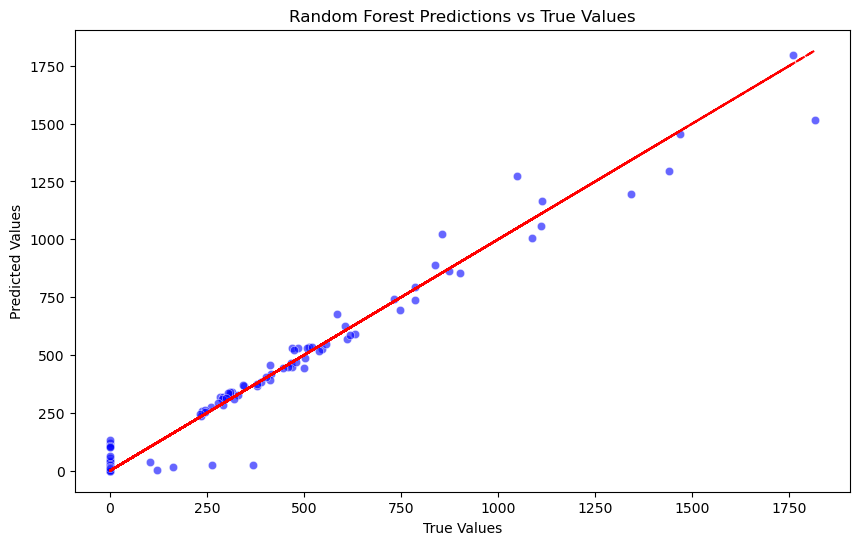

In [115]:
# Visualization for Random Forest
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=rf_predictions, color="blue", alpha=0.6)
plt.plot(y_test, y_test, color="red", linestyle="--")
plt.title("Random Forest Predictions vs True Values")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()




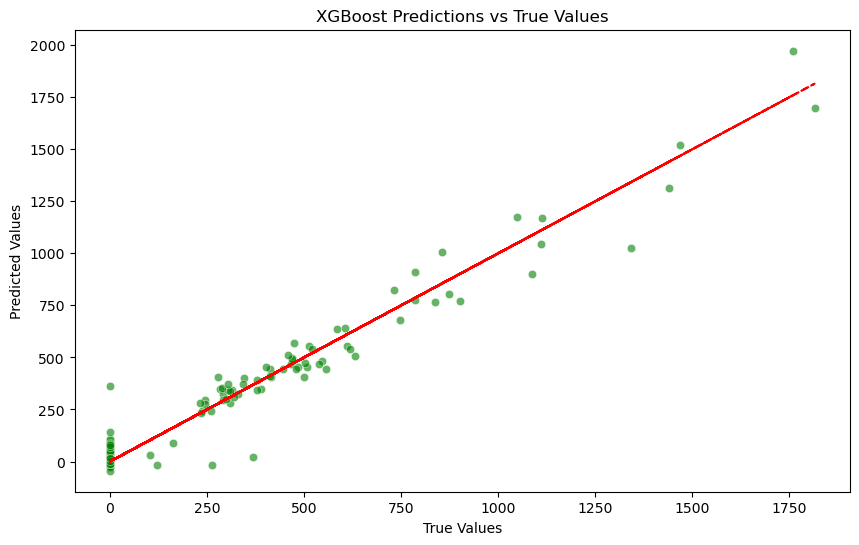

In [116]:
# Visualization for XGBoost
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=xgb_predictions, color="green", alpha=0.6)
plt.plot(y_test, y_test, color="red", linestyle="--")
plt.title("XGBoost Predictions vs True Values")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

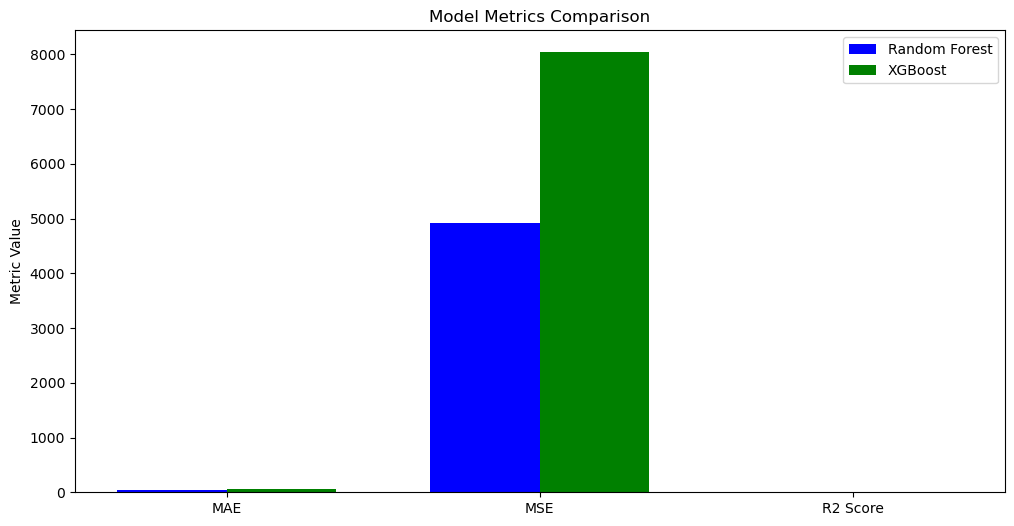

In [117]:
# Model comparison bar plot
metrics = ["MAE", "MSE", "R2 Score"]
rf_values = [rf_metrics["MAE"], rf_metrics["MSE"], rf_metrics["R2 Score"]]
xgb_values = [xgb_metrics["MAE"], xgb_metrics["MSE"], xgb_metrics["R2 Score"]]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, rf_values, width, label="Random Forest", color="blue")
plt.bar(x + width/2, xgb_values, width, label="XGBoost", color="green")
plt.xticks(x, metrics)
plt.ylabel("Metric Value")
plt.title("Model Metrics Comparison")
plt.legend()
plt.show()

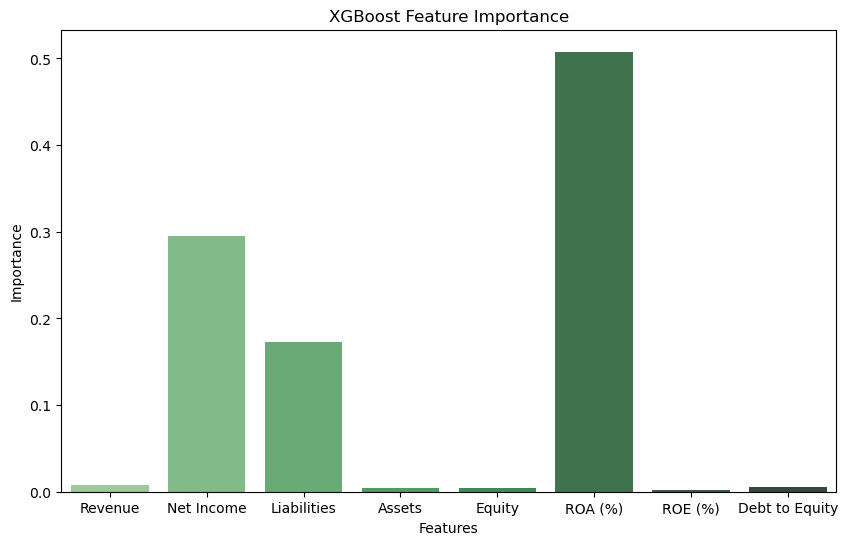

In [125]:
# Feature for XGBoost
plt.figure(figsize=(10, 6))
feature_importances_xgb = xgb_model.feature_importances_
sns.barplot(x=features, y=feature_importances_xgb, palette="Greens_d")
plt.title("XGBoost Feature Importance")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

In [ ]:
# Residual Plot for XGBoost
xgb_residuals = y_test - xgb_predictions
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=xgb_residuals, color="green", alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.title("XGBoost Residuals")
plt.xlabel("True Values")
plt.ylabel("Residuals")
plt.show()


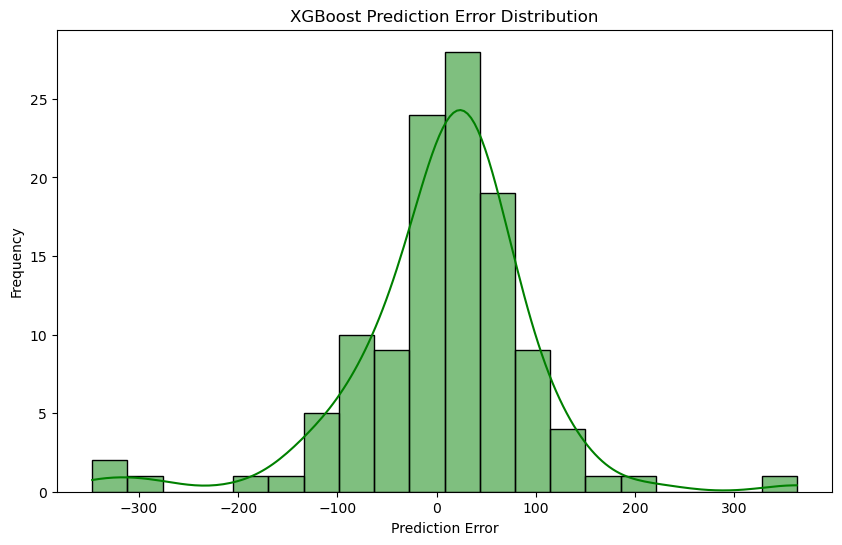

In [126]:
# Error Distribution for XGBoost
plt.figure(figsize=(10, 6))
xgb_errors = xgb_predictions - y_test
sns.histplot(xgb_errors, kde=True, color="green", bins=20)
plt.title("XGBoost Prediction Error Distribution")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.show()

In [127]:
# Display evaluation metrics
print("--- Model Evaluation ---")
print(pd.DataFrame([rf_metrics, xgb_metrics]))


--- Model Evaluation ---
           Model        MAE          MSE  R2 Score
0  Random Forest  38.954052  4924.303479  0.968211
1        XGBoost  61.115545  8038.038901  0.948110
